<div style="border: 2px solid red; padding: 10px; border-radius: 5px;">
<strong>Notebook description:</strong>
    
Plotting untargeted LCMS metabolomics on cells

<strong>Input Data:</strong>

`7689.SUB15127_MetabolomicsData_Targeted.xlsx` 


<strong>Figures:</strong>

`ED12`

<strong>Last Run All:</strong>
June 18, 2025


In [1]:
import seaborn as sns
sns.set_theme(style="white", context="talk")
import matplotlib as mpl
# For PDF output:
mpl.rcParams['pdf.fonttype'] = 42      # 42 = TrueType (editable)
# For SVG output:
mpl.rcParams['svg.fonttype'] = 'none' 

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica', 'Arial']

import matplotlib as mpl
mpl.rcParams.update({
    'font.size':        12,   # default text size
    'axes.labelsize':   14,   # x/y label size
    'xtick.labelsize':  12,   # tick label size
    'ytick.labelsize':  12,
    'legend.fontsize':  12,
    'axes.titlesize':   16,
})

In [2]:
# import packages
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind
import statsmodels.stats.multitest as smm
from adjustText import adjust_text
import os

from statannotations.Annotator import Annotator

load the data

In [3]:
# Load data 
output_dir = '../../../LCMS/'

# Load the Excel file
excel_file = os.path.join(output_dir, '7689.SUB15127_MetabolomicsData_Targeted.xlsx')

# Load the sheet into a DataFrame
sheet_name = 'Untargeted'  # Replace with the actual sheet name if different
data = pd.read_excel(excel_file, sheet_name=sheet_name)
metadata = pd.read_excel(excel_file, sheet_name='SamplesNames')

/Users/djuna/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [4]:
# Blanks already removed by core
'Background' in set(data.iloc[:,2].unique())


False

In [5]:
# get metadata
meta = metadata.iloc[2:]
meta.columns = metadata.iloc[1]
meta['grp'] = meta['Line'] + '_' + meta['Treatment']
dictionary = dict(zip(meta['CD file'], meta['grp']))
dictionary_outliers = dict(zip(meta['CD file'], meta['Exp']))

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_94442/2743206479.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta['grp'] = meta['Line'] + '_' + meta['Treatment']


In [6]:
# get the normalized areas
norm_areas = data.iloc[6:,64:95]
norm_areas.columns = [x.split('(')[1].split(')')[0] for x in norm_areas.iloc[0].values]
norm_areas = norm_areas[1:]
norm_areas.index = np.arange(len(norm_areas))
names = np.array([dictionary[x] for x in norm_areas.columns])
outliers = np.array([dictionary_outliers[x] for x in norm_areas.columns])

In [7]:
# remove the outliers
norm_areas_no_outliers = norm_areas.iloc[:,outliers!='outlier']
names_no_outliers = names[outliers!='outlier']
outliers_no_outliers = outliers[outliers!='outlier']

plot PCA projection

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


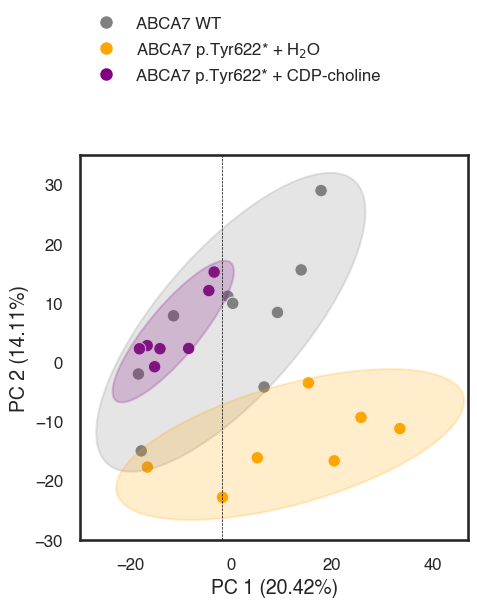

In [8]:
# only look at E3, Y, YC
names_subset = np.where((names_no_outliers!='G2_H2O'))[0]
norm_areas_subset = norm_areas_no_outliers.iloc[:,names_subset]
names_subset = names_no_outliers[names_subset]

# perform PCA
scaler = StandardScaler()
norm_areas_subset_no_background_scaled = scaler.fit_transform(norm_areas_subset.T)

pca = PCA(n_components=4)
principal_components = pca.fit_transform(norm_areas_subset_no_background_scaled)
principal_components = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])
principal_components['condition'] = names_subset

# plot PCA
plt.figure(figsize=(5, 5))
palette = {'E3_H2O': 'grey', 'Y_H2O': 'orange', 'Y_C': 'purple', 'G2_H2O': 'blue'}
sns.scatterplot(x='PC1', y='PC2', hue='condition', data=principal_components, palette=palette, edgecolor='w')
explained_variance = pca.explained_variance_ratio_
plt.xlabel(f'PC 1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC 2 ({explained_variance[1]*100:.2f}%)')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
# Remove the existing legend
plt.legend([],[], frameon=False)

import matplotlib.patches as patches
for treatment in principal_components['condition'].unique():
    line_data = principal_components[principal_components['condition'] == treatment]
    confidence_ellipse = np.cov(line_data['PC1'], line_data['PC2'])
    eigenvals, eigenvecs = np.linalg.eig(confidence_ellipse)
    angle = np.degrees(np.arctan2(eigenvecs[1,0], eigenvecs[0,0]))
    
    ellipse = patches.Ellipse(xy=(line_data['PC1'].mean(), line_data['PC2'].mean()),
                            width=2*np.sqrt(eigenvals[0])*2,
                            height=2*np.sqrt(eigenvals[1])*2,
                            angle=angle,
                            fill=True,
                            alpha=0.2,
                            color=palette[treatment])
    plt.gca().add_patch(ellipse)

explained_variance = pca.explained_variance_ratio_
plt.xlabel(f'PC 1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC 2 ({explained_variance[1]*100:.2f}%)')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
# Remove the existing legend
plt.legend([],[], frameon=False)

# Add a custom legend based on marker type
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='grey', markersize=10,linestyle='None', label='ABCA7 WT'),
           
           Line2D([0], [0], marker='o', markerfacecolor='orange',color='w',
           markersize=10, linestyle='None', label='ABCA7 p.Tyr622* + H$_2$O'),
           Line2D([0], [0], marker='o', markerfacecolor='purple',color='w',
           markersize=10, linestyle='None', label='ABCA7 p.Tyr622* + CDP-choline')
]
plt.legend(handles=legend_elements, title='', bbox_to_anchor=(.4, 1.4), loc='upper center', frameon=False)
# Add vertical line along the mean of PC1
mean_pc1 = principal_components['PC1'].median()
plt.axvline(x=mean_pc1, color='black', linestyle='--',  linewidth=0.5)

plt.xlim(-30,47)
plt.ylim(-30,35)
plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/ed12/pca_plot_y622_choline_metab.pdf', bbox_inches='tight')



Show the CVs

In [9]:
X = np.array(norm_areas_no_outliers).astype(float)
y = np.array(names_no_outliers)

In [10]:
target = ['E3_H2O', 'Y_H2O', 'Y_C']
for t in target:
    Xi = X[:,y==t]
    CV = np.std(Xi, axis=1)/np.mean(Xi, axis=1)
    print(t, np.median(CV))

E3_H2O 0.6121711128449903
Y_H2O 0.554828820523819
Y_C 0.43510007697998154
